# Using Machine learning approach to predict maximum possible magnitude of induced earthquakes. 



In [118]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Keras related modules
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Sklearn related modules
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Plot related modules
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd

random_seed = 100
np.random.seed(random_seed)

### Functions

In [119]:
def load_data(model):
    
    data_file=  model+'_data_dropped_all_data.txt'
    df_all= pd.read_csv(data_file, sep=",", header = None)
    
    features_name =  ['label', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'height']
    df_all.columns = features_name
    
    df_all['label'] = np.where(df_all['label']> 4.0, 1.0, 0.0)
    #df_all.head(3)

    msk = np.random.rand(len(df_all)) < 0.8
    train = df_all[msk]
    train_val= df_all[~msk]

    len_train_val = int (len(train_val)/2.0)
    test = train_val[0:len_train_val]
    valid = train_val[len_train_val::]

    return train, test, valid


def prediction(xdata, ydata, threshold = 0.50):
    ypred_test_prob = model.predict(xdata)
    ypred_bin = [1.0 if val > threshold  else 0.0 for val in ypred_test_prob]
    print('Accuracy of the model: {}\n'.format(accuracy_score(ydata, ypred_bin)))
    print('Classification report: \n{}\n'.format(classification_report(ydata, ypred_bin)))
    #print('Confusion matrix: \n{}\n'.format(confusion_matrix(ydata, ypred_bin)))
    return ypred_bin


# Main program

#### Classification problem
#### We are running the problem with RMS height of fault only, but this time, we are just interested to know if the rupture become big or die out early


In [120]:
# We are loading the data
df_train, df_test, df_val = load_data('aug_18')
# print(df_train.describe())

features_name =  ['label', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'height']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

# some pre-processing of data 

df = shuffle(df_train_all, random_state = random_seed)
df_train = shuffle(df_train, random_state = random_seed)
df_val = shuffle(df_val, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)


mms = StandardScaler()
train_scale = mms.fit(df.drop('label', axis=1))

xtrain_all = train_scale.transform(df.drop('label', axis=1))
ytrain_all =  df['label'].values

xtrain = train_scale.transform(df_train.drop('label', axis=1))
ytrain = df_train['label'].values

xval = train_scale.transform(df_val.drop('label', axis=1))
yval = df_val['label'].values

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/Cell

In [121]:
df_train_new = pd.DataFrame(xtrain, columns= features_name[:-1])
df_train_new['label'] = df_train['label']
df_train_all.describe()

,label,width,sxx,sxy,syy,sdrop,mud,dc,height
count,3572.000000,3572.000000,3572.000000,3572.000000,3572.000000,3572.000000,3572.000000,3572.000000,3572.000000
mean,0.658455,0.248877,1037.916013,0.712287,0.267523,-17.653658,-18.278628,7.035064,0.015478
std,0.474294,0.272683,324.344112,0.060879,0.058624,7.850068,7.261852,3.159619,0.008378
min,0.000000,0.000020,480.000000,0.601154,0.200031,-65.213529,-69.804422,2.784483,0.001007
25%,0.000000,0.047744,757.000000,0.662487,0.220519,-21.592435,-22.325708,4.693149,0.008246
50%,1.000000,0.127277,1041.000000,0.708349,0.250791,-15.702849,-16.368693,6.117167,0.015625
75%,1.000000,0.375697,1319.250000,0.760089,0.301265,-11.787455,-12.636967,8.678432,0.022559
max,1.000000,0.999215,1600.000000,1.000279,0.603016,-7.580383,-10.000589,33.919161,0.029992


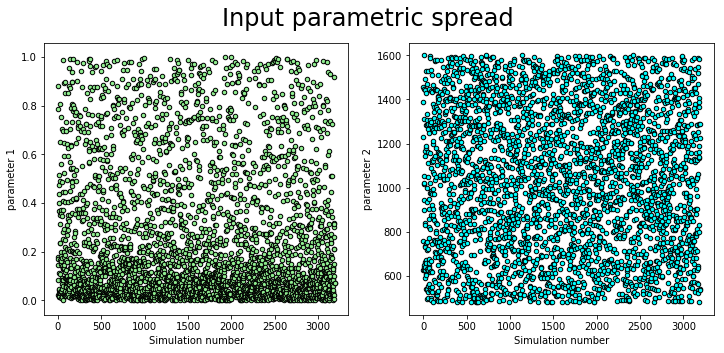

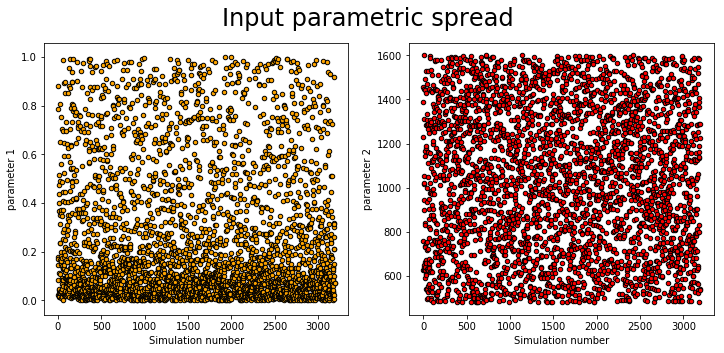

In [122]:
# # Load and clean data
# m, n, params, y = load_data('aug18')

# # normalize the parameters for the training data file
# train_mean = np.mean(params, axis=0)
# train_std = np.std(params, axis=0)
# params = params-train_mean
# params = params/train_std 
# # Since we are doing supervised learning, it is convinient to take a general look at the data.

len_of_data= int (len(df_train))
x= np.linspace(0, len_of_data-1,len_of_data )
parameter_2= np.array(df_train.iloc[:, [2]])
parameter_1= np.array(df_train.iloc[:, [1]])
# # Take a look at few parameteric spread.
figure, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12, 5))
figure.suptitle('Input parametric spread', fontsize= 24)
ax1.scatter(x, parameter_1, facecolors='lightgreen', edgecolors='black', s=20, label='5 km away')
ax2.scatter(x, parameter_2, facecolors='cyan', edgecolors='black', s=20, label='5 km away')
ax1.set_xlabel('Simulation number')
ax1.set_ylabel('parameter 1')
ax2.set_xlabel('Simulation number')
ax2.set_ylabel('parameter 2')
plt.show()

parameter_3= np.array(df_train.iloc[:, [3]])
parameter_4= np.array(df_train.iloc[:, [4]])
figure, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12, 5))
figure.suptitle('Input parametric spread', fontsize= 24)
ax1.scatter(x, parameter_1, facecolors='orange', edgecolors='black', s=20, label='5 km away')
ax2.scatter(x, parameter_2, facecolors='red', edgecolors='black', s=20, label='5 km away')
ax1.set_xlabel('Simulation number')
ax1.set_ylabel('parameter 1')
ax2.set_xlabel('Simulation number')
ax2.set_ylabel('parameter 2')
plt.show()




### Classification problem sometimes the class distribution 





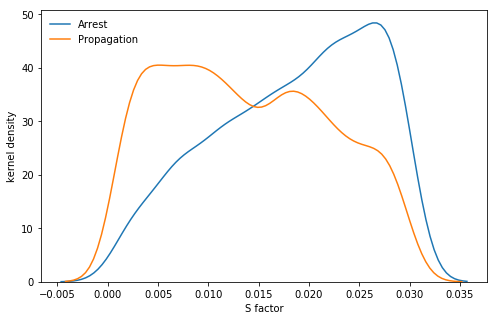

In [123]:
plt.figure(figsize=(8, 5))
sns.kdeplot(abs(df_train_all['height'][df_train_all.label == 0]), shade= False)
sns.kdeplot(abs(df_train_all['height'][df_train_all.label == 1]), shade= False)
plt.legend(['Arrest', 'Propagation'], 
           loc = 'upper left',
           framealpha = 0.0)

plt.xlabel('S factor')
plt.ylabel('kernel density')
#plt.tight_layout()
plt.show()

In [124]:
class_name = ['Rupture arrest', 'Rupture propagate']
count = list(label_count['label'])
print('Rupture propagate : {}, \nRupture arrest: {}'.format(count[0], count[1]))
print('Total number of data: {}'.format(np.sum(count)))
print('Class ratio for rupture propagation: {}'.format(count[0]/count[1]))

Rupture propagate : 0.0, 
Rupture arrest: 1.0
Total number of data: 1.0
Class ratio for rupture propagation: 0.0


[ 1.46393443  0.75935374]
{0: 1.4639344262295082, 1: 0.75935374149659862}


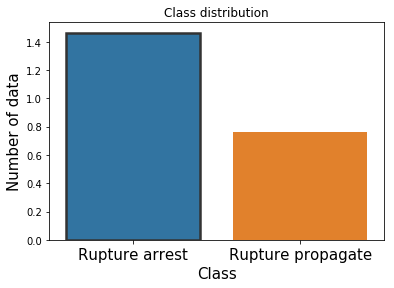

In [125]:
aa = class_weight.compute_class_weight('balanced', np.unique(ytrain_all.astype(int)), ytrain_all.astype(int))
print (aa)
CLASS_WEIGHT = {0 : aa[0] , 1: aa[1]}
print (CLASS_WEIGHT)

index = np.arange(len(class_name))
class_name = ['Rupture arrest', 'Rupture propagate']

# plt.bar(class_name, count)
sns.barplot(x = class_name, y = aa, linewidth = 2.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

### TRAIN MODEL

In [126]:
HIDDEN_LAYER_SIZE = 12
L2_REGULARIZER = 5
LEARNING_RATE = 0.0025
TRAINING_EPOCHS = 2000
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.30
CLASS_WEIGHT = CLASS_WEIGHT



model = Sequential()
model.add(Dense(HIDDEN_LAYER_SIZE, 
                activation = 'relu',
                kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = 1, seed = 100),
                bias_initializer = 'Ones',
                input_shape = (8,),
                kernel_regularizer = regularizers.l2(L2_REGULARIZER),
                name = 'layer_1'))

adm_optz = optimizers.Adam(lr = LEARNING_RATE)

model.add(Dense(1, activation = "sigmoid", name = 'Output_layer'))
model.compile(optimizer = adm_optz, loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)
              
callback_list = [early_stopping]

history = model.fit(xtrain_all, ytrain_all, 
                    batch_size = BATCH_SIZE, 
                    epochs = TRAINING_EPOCHS,
                    class_weight = CLASS_WEIGHT,
                    callbacks = callback_list,
                    validation_split = VALIDATION_SPLIT, 
                    verbose = 0)



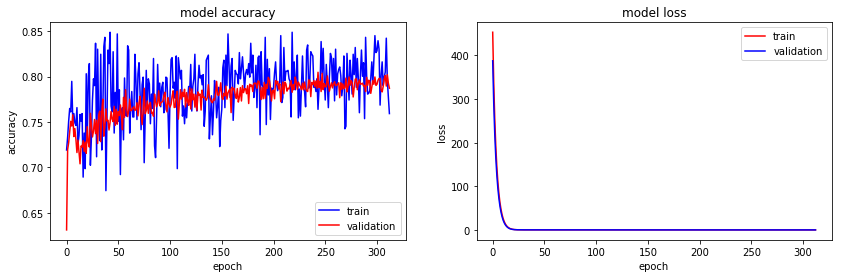

In [127]:
# Checking how the model is behaving with iterations
plt.figure(figsize= (14, 4))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_acc'], 'b-')
plt.plot(history.history['acc'], 'r-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
    

    ### ROC curve analysis 

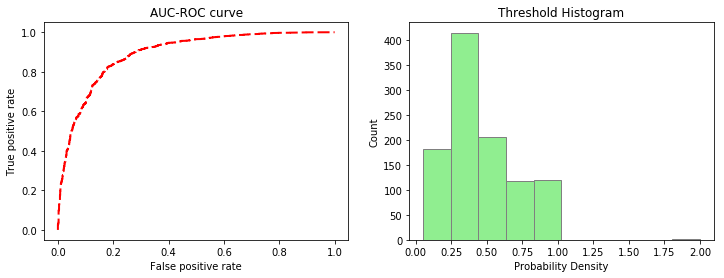

In [128]:
ypred_train = model.predict(xtrain_all)

from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score = roc_auc_score(ytrain_all, ypred_train)
fpr, tpr, thresholds = roc_curve(ytrain_all, ypred_train, pos_label = 1)

plt.figure(figsize=(12, 4))
plt.subplot(1,2, 1)
plt.plot(fpr, tpr, 'r', linewidth=2, dashes=[6, 2])
plt.title('AUC-ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.subplot(1, 2, 2)
plt.hist(thresholds, facecolor='lightgreen', edgecolor='gray')
plt.title('Threshold Histogram')
plt.xlabel('Probability Density')
plt.ylabel('Count')
plt.show()


## Check how well the model behaved 

In [129]:
THRESHOLD = np.median(thresholds)

# Training data results
prdiction_train=prediction(xtrain_all, ytrain_all, threshold = THRESHOLD)

# Test data results
prediction_test=prediction(xtest, ytest, threshold = 0.50)


Accuracy of the model: 0.8225083986562151

Classification report: 
              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76      1220
         1.0       0.89      0.83      0.86      2352

   micro avg       0.82      0.82      0.82      3572
   macro avg       0.80      0.82      0.81      3572
weighted avg       0.83      0.82      0.83      3572


Accuracy of the model: 0.7847769028871391

Classification report: 
              precision    recall  f1-score   support

         0.0       0.61      0.79      0.69       116
         1.0       0.90      0.78      0.83       265

   micro avg       0.78      0.78      0.78       381
   macro avg       0.75      0.79      0.76       381
weighted avg       0.81      0.78      0.79       381




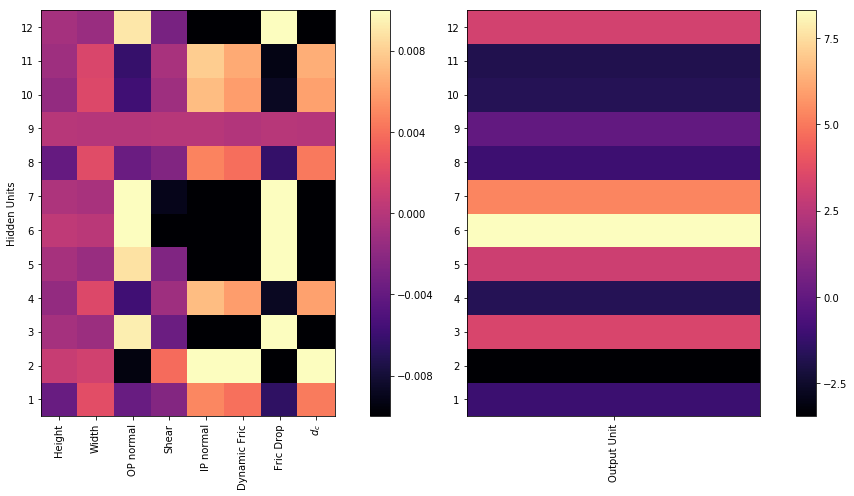

In [130]:
filename = './rupture_best_model.h5'
model.save(filename)

model_weights = []
filename = './rupture_best_model.h5'

loaded_model = load_model(filename)

weights = loaded_model.get_weights()

layer_1_weights = weights[0]    
layer_2_weights = weights[2]

from matplotlib import ticker

plt.figure(figsize=(12, 7))

plt.subplot(1,2, 1)
aa = np.transpose(layer_1_weights)
plt.pcolormesh(aa, cmap = 'magma', vmin = -0.010, vmax = 0.010)
labels = ['Height', 'Width', 'OP normal', 'Shear', 'IP normal', 'Dynamic Fric', 'Fric Drop', '$d_c$']

plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
plt.ylabel('Hidden Units')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# Layer two plot
plt.subplot(1, 2, 2)
bb = np.reshape(layer_2_weights, (12, 1))
plt.pcolormesh(bb, cmap = 'magma')
plt.xticks([0.5],['Output Unit'],rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

plt.tight_layout()
plt.savefig('weight_vs_features.eps')
plt.show()

## We are running the regression problem with full fault spectrum using PCA analysis

In [131]:
from keras.utils import to_categorical

mms = StandardScaler()
X_train = mms.fit_transform(df_train.drop('label', axis=1))
Y_train = to_categorical(df_train['label'].values)

# X_val = mms.fit_transform(df_val.drop('value', axis=1))
# Y_val = to_categorical(df_val['value'].values)

# X_test = mms.fit_transform(df_test.drop('value', axis=1))
# Y_test = to_categorical(df_test['value'].values)

pca = PCA()
pca_result = pca.fit_transform(X_train)
df_train['pca_one'] = pca_result[:,0]
df_train['pca_two'] = pca_result[:,1]
df_train['pca_three'] = pca_result[:,2]

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[ 0.35935063  0.2066061   0.12750508  0.12290817  0.11866964  0.03999476
  0.01943766  0.00552795]


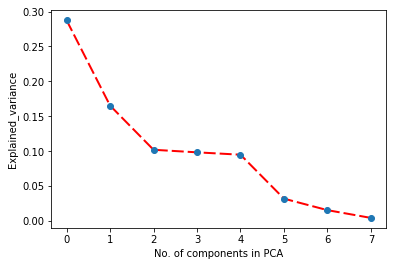

In [132]:
print (pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_/10.0, linewidth=2, dashes=[6, 2], color='red')
plt.plot(pca.explained_variance_/10.0, 'o')
plt.axis('tight')
plt.xlabel('No. of components in PCA')
plt.ylabel('Explained_variance')
plt.show()


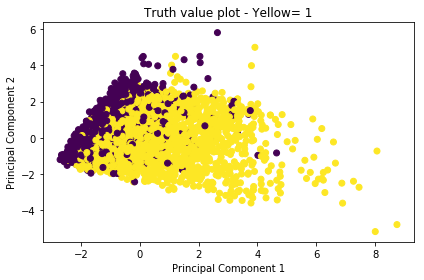

In [133]:
plt.scatter(df_train['pca_one'], df_train['pca_two'], c=df_train['label'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Truth value plot - Yellow= 1')
plt.tight_layout()
plt.show()